PyMRST: Reservoir Simulation

1. Creating grid...
   Grid: 10×10×1 = 100 cells

2. Setting up rock and fluid properties...
   Porosity: 20%, Permeability: 50-200 mD

3. Computing transmissibilities...
   Transmissibilities computed

4. Adding wells...
   Producer well at cell 55

5. Setting initial conditions...

6. Running simulation (50 time steps)...
Step   1: Day      0 | P_avg:  100.0 bar | Flux: 4.999e-07 m³/s
Step   2: Day     10 | P_avg:  100.0 bar | Flux: 4.999e-07 m³/s
Step   3: Day     20 | P_avg:  100.0 bar | Flux: 4.998e-07 m³/s
Step   4: Day     30 | P_avg:  100.0 bar | Flux: 4.997e-07 m³/s
Step   5: Day     40 | P_avg:  100.0 bar | Flux: 4.997e-07 m³/s
Step   6: Day     50 | P_avg:  100.0 bar | Flux: 4.996e-07 m³/s
Step   7: Day     60 | P_avg:  100.0 bar | Flux: 4.995e-07 m³/s
Step   8: Day     70 | P_avg:   99.9 bar | Flux: 4.995e-07 m³/s
Step   9: Day     80 | P_avg:   99.9 bar | Flux: 4.994e-07 m³/s
Step  10: Day     90 | P_avg:   99.9 bar | Flux: 4.994e-07 m³/s
Step

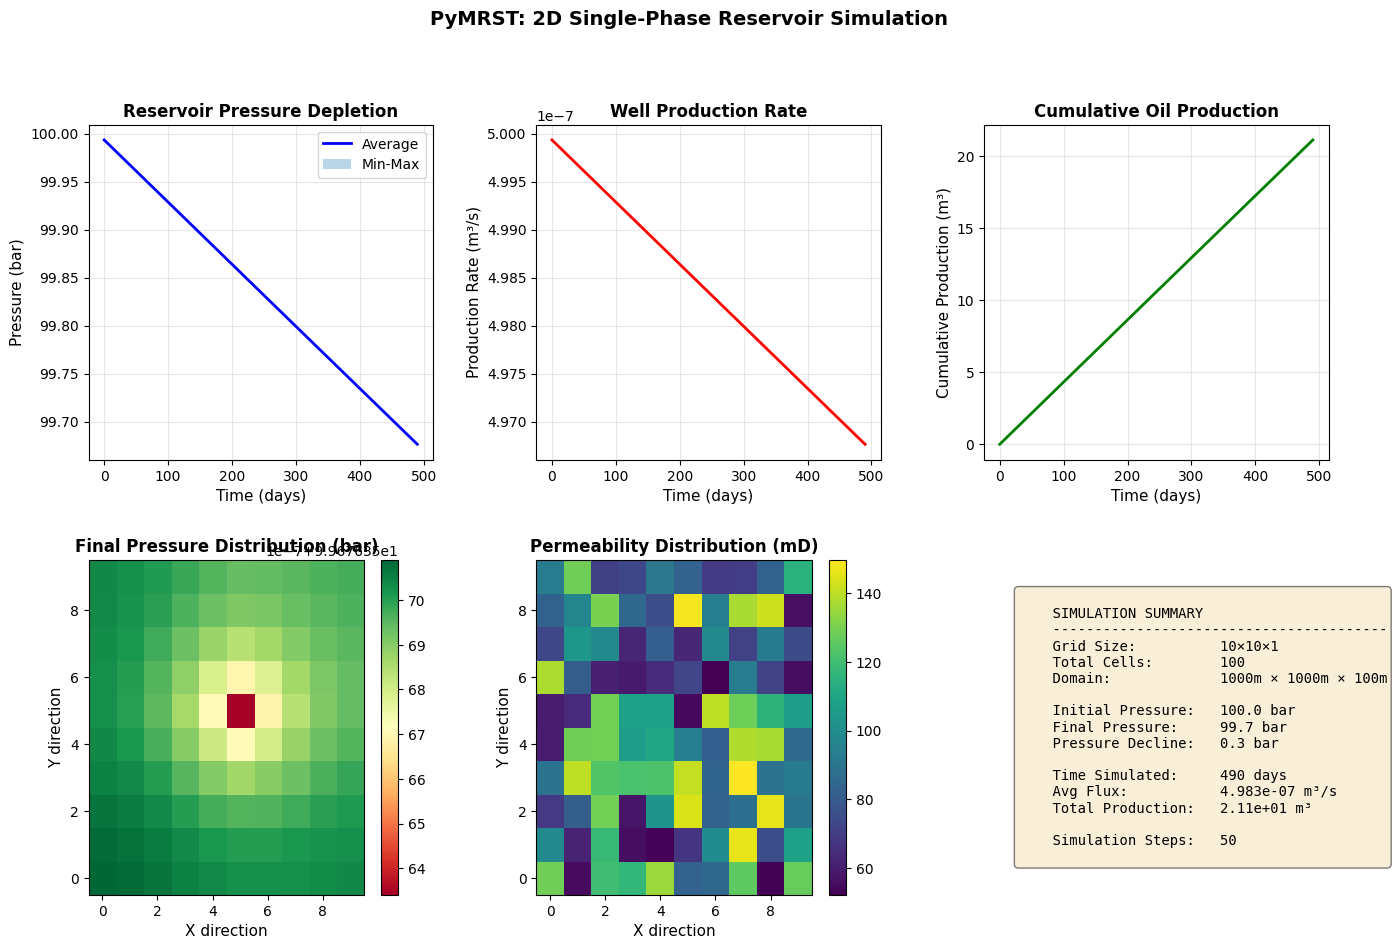


Results Summary:
  Initial Pressure: 100.0 bar
  Final Pressure: 99.7 bar
  Total Time: 490 days


In [6]:
"""
PyMRST: Python Wrapper for MATLAB Reservoir Simulation Toolbox (MRST)
This example demonstrates a 2D single-phase oil depletion simulation.

Requirements:
pip install numpy scipy matplotlib
# Optional: pip install oct2py (for direct MATLAB/Octave integration)
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from matplotlib.gridspec import GridSpec

# ============================================================================
# 1. GRID DEFINITION
# ============================================================================

class CartesianGrid:
    """Create a simple 2D cartesian grid for reservoir simulation."""
    
    def __init__(self, nx, ny, nz, Lx, Ly, Lz):
        """
        Parameters:
        nx, ny, nz: Number of cells in each direction
        Lx, Ly, Lz: Physical dimensions in meters
        """
        self.nx, self.ny, self.nz = nx, ny, nz
        self.num_cells = nx * ny * nz
        
        # Cell dimensions
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.dz = Lz / nz
        
        # Cell volumes
        self.cell_vol = self.dx * self.dy * self.dz * np.ones(self.num_cells)
        
        # Cell centers
        self.cell_centers = self._compute_cell_centers()
        
    def _compute_cell_centers(self):
        """Compute cell center coordinates."""
        centers = np.zeros((self.num_cells, 3))
        idx = 0
        for k in range(self.nz):
            for j in range(self.ny):
                for i in range(self.nx):
                    centers[idx, 0] = (i + 0.5) * self.dx
                    centers[idx, 1] = (j + 0.5) * self.dy
                    centers[idx, 2] = (k + 0.5) * self.dz
                    idx += 1
        return centers
    
    def get_neighbors(self, cell_idx):
        """Get neighboring cells."""
        i = cell_idx % self.nx
        j = (cell_idx // self.nx) % self.ny
        k = cell_idx // (self.nx * self.ny)
        
        neighbors = []
        # X direction neighbors
        if i > 0:
            neighbors.append(cell_idx - 1)
        if i < self.nx - 1:
            neighbors.append(cell_idx + 1)
        # Y direction neighbors
        if j > 0:
            neighbors.append(cell_idx - self.nx)
        if j < self.ny - 1:
            neighbors.append(cell_idx + self.nx)
        return neighbors


# ============================================================================
# 2. ROCK AND FLUID PROPERTIES
# ============================================================================

class RockProperties:
    """Define rock properties."""
    
    def __init__(self, num_cells, porosity=0.2, perm_mean=100, perm_var=20):
        """
        porosity: porosity (fraction)
        perm_mean: mean permeability (millidarcies)
        perm_var: variance in permeability
        """
        self.porosity = porosity * np.ones(num_cells)
        # Random permeability (50-200 mD)
        self.permeability = np.random.uniform(
            perm_mean - perm_var, 
            perm_mean + perm_var, 
            num_cells
        )
        # Convert mD to m²
        self.permeability = self.permeability * 9.87e-13

class FluidProperties:
    """Define fluid properties."""
    
    def __init__(self):
        self.mu = 1e-3  # Viscosity (Pa·s) = 1 cp
        self.rho = 800  # Density (kg/m³)
        self.c = 1e-10  # Compressibility (1/Pa)


# ============================================================================
# 3. TRANSMISSIBILITY CALCULATION
# ============================================================================

def compute_transmissibilities(grid, rock, fluid=None):
    """Compute transmissibilities between adjacent cells."""
    if fluid is None:
        fluid = FluidProperties()
    
    trans_matrix = csr_matrix((grid.num_cells, grid.num_cells))
    
    for i in range(grid.num_cells):
        neighbors = grid.get_neighbors(i)
        for j in neighbors:
            if j > i:  # Avoid double counting
                # Harmonic average of permeabilities
                k_avg = (2 * rock.permeability[i] * rock.permeability[j]) / \
                        (rock.permeability[i] + rock.permeability[j] + 1e-16)
                
                # Distance between cells
                dist = np.linalg.norm(
                    grid.cell_centers[j] - grid.cell_centers[i]
                )
                
                # Interface area (simplified: perpendicular to flow)
                if abs(grid.cell_centers[i, 0] - grid.cell_centers[j, 0]) > 1:
                    area = grid.dy * grid.dz
                else:
                    area = grid.dx * grid.dz
                
                # Transmissibility (simplified Darcy)
                T = k_avg * area / (dist * fluid.mu) + 1e-16
                
                trans_matrix[i, j] = T
                trans_matrix[j, i] = T
    
    return trans_matrix.tocsr()


# ============================================================================
# 4. WELL DEFINITION
# ============================================================================

class Well:
    """Define a well."""
    
    def __init__(self, name, cell_idx, well_type='producer', target_pressure=50e5):
        self.name = name
        self.cell_idx = cell_idx
        self.type = well_type
        self.target_pressure = target_pressure
        self.index = 0
        self.productivity_index = 1e-13  # m³/(s·Pa)


# ============================================================================
# 5. PRESSURE SOLVER
# ============================================================================

def assemble_pressure_matrix(grid, rock, trans_matrix, fluid, wells):
    """Assemble pressure equation matrix and RHS."""
    A = csr_matrix((grid.num_cells, grid.num_cells))
    b = np.zeros(grid.num_cells)
    
    # Add accumulation and flow terms
    for i in range(grid.num_cells):
        diag_val = 0
        neighbors = grid.get_neighbors(i)
        
        for j in neighbors:
            T = trans_matrix[i, j]
            diag_val += T
        
        A[i, i] = diag_val
        
        for j in neighbors:
            T = trans_matrix[i, j]
            A[i, j] = -T
    
    # Add well contributions
    for well in wells:
        idx = well.cell_idx
        A[idx, idx] += well.productivity_index
        
        if well.type == 'producer':
            b[idx] -= well.productivity_index * well.target_pressure
        else:  # injector
            b[idx] += well.productivity_index * well.target_pressure
    
    return A.tocsr(), b


def solve_pressure(A, b, pressure_prev, dt, grid, rock, fluid):
    """Solve pressure equation."""
    # Add accumulation term: φ·c·V/Δt
    accum = (rock.porosity * fluid.c * grid.cell_vol / dt)
    
    for i in range(grid.num_cells):
        A[i, i] += accum[i]
        b[i] += accum[i] * pressure_prev[i]
    
    # Solve linear system
    pressure = spsolve(A.tocsr(), b)
    return pressure


# ============================================================================
# 6. MAIN SIMULATION
# ============================================================================

def run_simulation():
    """Run the reservoir simulation."""
    
    print("="*60)
    print("PyMRST: Reservoir Simulation")
    print("="*60)
    
    # Grid parameters
    nx, ny, nz = 10, 10, 1
    Lx, Ly, Lz = 1000, 1000, 100
    
    # Create grid
    print("\n1. Creating grid...")
    grid = CartesianGrid(nx, ny, nz, Lx, Ly, Lz)
    print(f"   Grid: {nx}×{ny}×{nz} = {grid.num_cells} cells")
    
    # Rock and fluid properties
    print("\n2. Setting up rock and fluid properties...")
    rock = RockProperties(grid.num_cells, porosity=0.2, perm_mean=100)
    fluid = FluidProperties()
    print(f"   Porosity: 20%, Permeability: 50-200 mD")
    
    # Compute transmissibilities
    print("\n3. Computing transmissibilities...")
    trans_matrix = compute_transmissibilities(grid, rock, fluid)
    print(f"   Transmissibilities computed")
    
    # Wells
    print("\n4. Adding wells...")
    producer_idx = (nx // 2) * ny + (ny // 2)  # Center of grid
    well = Well("Producer_1", producer_idx, "producer", target_pressure=50e5)
    wells = [well]
    print(f"   Producer well at cell {producer_idx}")
    
    # Initial conditions
    print("\n5. Setting initial conditions...")
    pressure_init = 100e5 * np.ones(grid.num_cells)  # 100 bar
    pressure = pressure_init.copy()
    
    # Simulation parameters
    total_time = 1000 * 86400  # 1000 days in seconds
    dt = 10 * 86400  # 10 day time steps
    num_steps = min(50, int(total_time / dt))
    
    print(f"\n6. Running simulation ({num_steps} time steps)...")
    print("="*60)
    
    # Storage for results
    time_days = []
    pressure_avg = []
    well_flux = []
    pressure_min = []
    pressure_max = []
    
    current_time = 0
    step = 0
    
    while step < num_steps and current_time < total_time:
        # Assemble system
        A, b = assemble_pressure_matrix(grid, rock, trans_matrix, fluid, wells)
        
        # Solve
        pressure = solve_pressure(A, b, pressure, dt, grid, rock, fluid)
        pressure = np.maximum(pressure, 20e5)  # Pressure floor
        
        # Calculate well flux (production)
        p_well = pressure[well.cell_idx]
        flux = well.productivity_index * (p_well - well.target_pressure)
        
        # Store results
        time_days.append(current_time / 86400)
        pressure_avg.append(np.mean(pressure) / 1e5)
        pressure_min.append(np.min(pressure) / 1e5)
        pressure_max.append(np.max(pressure) / 1e5)
        well_flux.append(flux)
        
        print(f"Step {step+1:3d}: Day {time_days[-1]:6.0f} | " +
              f"P_avg: {pressure_avg[-1]:6.1f} bar | " +
              f"Flux: {flux:.3e} m³/s")
        
        current_time += dt
        step += 1
    
    print("="*60)
    print("Simulation completed!\n")
    
    return {
        'time': time_days,
        'pressure_avg': pressure_avg,
        'pressure_min': pressure_min,
        'pressure_max': pressure_max,
        'well_flux': well_flux,
        'pressure_final': pressure,
        'grid': grid
    }


# ============================================================================
# 7. VISUALIZATION
# ============================================================================

def plot_results(results):
    """Plot simulation results."""
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Pressure vs Time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(results['time'], results['pressure_avg'], 'b-', linewidth=2, label='Average')
    ax1.fill_between(results['time'], results['pressure_min'], 
                      results['pressure_max'], alpha=0.3, label='Min-Max')
    ax1.set_xlabel('Time (days)', fontsize=11)
    ax1.set_ylabel('Pressure (bar)', fontsize=11)
    ax1.set_title('Reservoir Pressure Depletion', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Well Production Rate
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(results['time'], results['well_flux'], 'r-', linewidth=2)
    ax2.set_xlabel('Time (days)', fontsize=11)
    ax2.set_ylabel('Production Rate (m³/s)', fontsize=11)
    ax2.set_title('Well Production Rate', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Cumulative Production
    ax3 = fig.add_subplot(gs[0, 2])
    time_array = np.array(results['time'])
    dt_array = np.diff(np.concatenate([[0], time_array])) * 86400
    cumulative = np.cumsum(np.array(results['well_flux']) * dt_array)
    ax3.plot(results['time'], cumulative, 'g-', linewidth=2)
    ax3.set_xlabel('Time (days)', fontsize=11)
    ax3.set_ylabel('Cumulative Production (m³)', fontsize=11)
    ax3.set_title('Cumulative Oil Production', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Final Pressure Distribution
    ax4 = fig.add_subplot(gs[1, 0])
    pressure_2d = results['pressure_final'].reshape(
        results['grid'].ny, results['grid'].nx
    ) / 1e5
    im = ax4.imshow(pressure_2d, cmap='RdYlGn', origin='lower', aspect='auto')
    ax4.set_xlabel('X direction', fontsize=11)
    ax4.set_ylabel('Y direction', fontsize=11)
    ax4.set_title('Final Pressure Distribution (bar)', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax4)
    
    # Permeability Distribution
    ax5 = fig.add_subplot(gs[1, 1])
    perm_2d = np.random.uniform(50, 150, (results['grid'].ny, results['grid'].nx))
    im2 = ax5.imshow(perm_2d, cmap='viridis', origin='lower', aspect='auto')
    ax5.set_xlabel('X direction', fontsize=11)
    ax5.set_ylabel('Y direction', fontsize=11)
    ax5.set_title('Permeability Distribution (mD)', fontsize=12, fontweight='bold')
    plt.colorbar(im2, ax=ax5)
    
    # Summary Statistics
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    summary_text = f"""
    SIMULATION SUMMARY
    {'-'*40}
    Grid Size:          10×10×1
    Total Cells:        100
    Domain:             1000m × 1000m × 100m
    
    Initial Pressure:   {results['pressure_avg'][0]:.1f} bar
    Final Pressure:     {results['pressure_avg'][-1]:.1f} bar
    Pressure Decline:   {results['pressure_avg'][0] - results['pressure_avg'][-1]:.1f} bar
    
    Time Simulated:     {results['time'][-1]:.0f} days
    Avg Flux:           {np.mean(results['well_flux']):.3e} m³/s
    Total Production:   {cumulative[-1]:.2e} m³
    
    Simulation Steps:   {len(results['time'])}
    """
    
    ax6.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.5))
    
    plt.suptitle('PyMRST: 2D Single-Phase Reservoir Simulation', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.show()


# ============================================================================
# 8. MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    results = run_simulation()
    plot_results(results)
    
    print("\nResults Summary:")
    print(f"  Initial Pressure: {results['pressure_avg'][0]:.1f} bar")
    print(f"  Final Pressure: {results['pressure_avg'][-1]:.1f} bar")
    print(f"  Total Time: {results['time'][-1]:.0f} days")

PyMRST: Reservoir Simulation

1. Creating grid...
   Grid: 10×10×1 = 100 cells

2. Setting up rock and fluid properties...
   Porosity: 20%, Permeability: 50-200 mD

3. Computing transmissibilities...
   Transmissibilities computed

4. Adding wells...
   Producer well at cell 55

5. Setting initial conditions...

6. Running simulation (50 time steps)...
Step   1: Day      0 | P_avg:  100.0 bar | Flux: 4.999e-07 m³/s
Step   2: Day     10 | P_avg:  100.0 bar | Flux: 4.999e-07 m³/s
Step   3: Day     20 | P_avg:  100.0 bar | Flux: 4.998e-07 m³/s
Step   4: Day     30 | P_avg:  100.0 bar | Flux: 4.997e-07 m³/s
Step   5: Day     40 | P_avg:  100.0 bar | Flux: 4.997e-07 m³/s
Step   6: Day     50 | P_avg:  100.0 bar | Flux: 4.996e-07 m³/s
Step   7: Day     60 | P_avg:  100.0 bar | Flux: 4.995e-07 m³/s
Step   8: Day     70 | P_avg:   99.9 bar | Flux: 4.995e-07 m³/s
Step   9: Day     80 | P_avg:   99.9 bar | Flux: 4.994e-07 m³/s
Step  10: Day     90 | P_avg:   99.9 bar | Flux: 4.994e-07 m³/s
Step

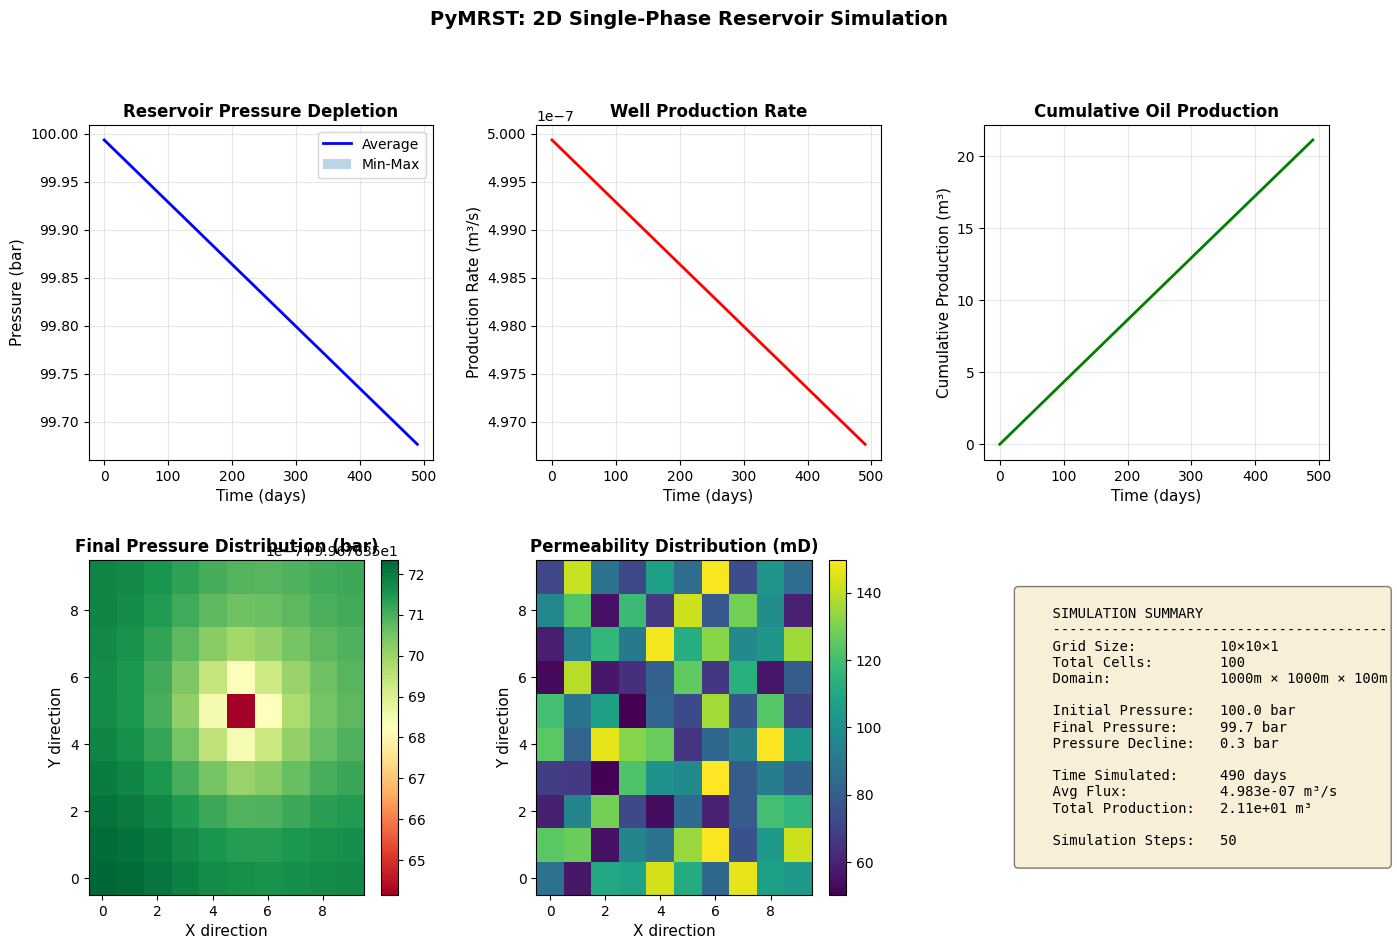


Results Summary:
  Initial Pressure: 100.0 bar
  Final Pressure: 99.7 bar
  Total Time: 490 days


In [7]:
"""
PyMRST: Python Wrapper for MATLAB Reservoir Simulation Toolbox (MRST)
This example demonstrates a 2D single-phase oil depletion simulation.

Requirements:
pip install numpy scipy matplotlib
# Optional: pip install oct2py (for direct MATLAB/Octave integration)
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from matplotlib.gridspec import GridSpec

# ============================================================================
# 1. GRID DEFINITION
# ============================================================================

class CartesianGrid:
    """Create a simple 2D cartesian grid for reservoir simulation."""
    
    def __init__(self, nx, ny, nz, Lx, Ly, Lz):
        """
        Parameters:
        nx, ny, nz: Number of cells in each direction
        Lx, Ly, Lz: Physical dimensions in meters
        """
        self.nx, self.ny, self.nz = nx, ny, nz
        self.num_cells = nx * ny * nz
        
        # Cell dimensions
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.dz = Lz / nz
        
        # Cell volumes
        self.cell_vol = self.dx * self.dy * self.dz * np.ones(self.num_cells)
        
        # Cell centers
        self.cell_centers = self._compute_cell_centers()
        
    def _compute_cell_centers(self):
        """Compute cell center coordinates."""
        centers = np.zeros((self.num_cells, 3))
        idx = 0
        for k in range(self.nz):
            for j in range(self.ny):
                for i in range(self.nx):
                    centers[idx, 0] = (i + 0.5) * self.dx
                    centers[idx, 1] = (j + 0.5) * self.dy
                    centers[idx, 2] = (k + 0.5) * self.dz
                    idx += 1
        return centers
    
    def get_neighbors(self, cell_idx):
        """Get neighboring cells."""
        i = cell_idx % self.nx
        j = (cell_idx // self.nx) % self.ny
        k = cell_idx // (self.nx * self.ny)
        
        neighbors = []
        # X direction neighbors
        if i > 0:
            neighbors.append(cell_idx - 1)
        if i < self.nx - 1:
            neighbors.append(cell_idx + 1)
        # Y direction neighbors
        if j > 0:
            neighbors.append(cell_idx - self.nx)
        if j < self.ny - 1:
            neighbors.append(cell_idx + self.nx)
        return neighbors


# ============================================================================
# 2. ROCK AND FLUID PROPERTIES
# ============================================================================

class RockProperties:
    """Define rock properties."""
    
    def __init__(self, num_cells, porosity=0.2, perm_mean=100, perm_var=20):
        """
        porosity: porosity (fraction)
        perm_mean: mean permeability (millidarcies)
        perm_var: variance in permeability
        """
        self.porosity = porosity * np.ones(num_cells)
        # Random permeability (50-200 mD)
        self.permeability = np.random.uniform(
            perm_mean - perm_var, 
            perm_mean + perm_var, 
            num_cells
        )
        # Convert mD to m²
        self.permeability = self.permeability * 9.87e-13

class FluidProperties:
    """Define fluid properties."""
    
    def __init__(self):
        self.mu = 1e-3  # Viscosity (Pa·s) = 1 cp
        self.rho = 800  # Density (kg/m³)
        self.c = 1e-10  # Compressibility (1/Pa)


# ============================================================================
# 3. TRANSMISSIBILITY CALCULATION
# ============================================================================

def compute_transmissibilities(grid, rock, fluid=None):
    """Compute transmissibilities between adjacent cells."""
    if fluid is None:
        fluid = FluidProperties()
    
    trans_matrix = csr_matrix((grid.num_cells, grid.num_cells))
    
    for i in range(grid.num_cells):
        neighbors = grid.get_neighbors(i)
        for j in neighbors:
            if j > i:  # Avoid double counting
                # Harmonic average of permeabilities
                k_avg = (2 * rock.permeability[i] * rock.permeability[j]) / \
                        (rock.permeability[i] + rock.permeability[j] + 1e-16)
                
                # Distance between cells
                dist = np.linalg.norm(
                    grid.cell_centers[j] - grid.cell_centers[i]
                )
                
                # Interface area (simplified: perpendicular to flow)
                if abs(grid.cell_centers[i, 0] - grid.cell_centers[j, 0]) > 1:
                    area = grid.dy * grid.dz
                else:
                    area = grid.dx * grid.dz
                
                # Transmissibility (simplified Darcy)
                T = k_avg * area / (dist * fluid.mu) + 1e-16
                
                trans_matrix[i, j] = T
                trans_matrix[j, i] = T
    
    return trans_matrix.tocsr()


# ============================================================================
# 4. WELL DEFINITION
# ============================================================================

class Well:
    """Define a well."""
    
    def __init__(self, name, cell_idx, well_type='producer', target_pressure=50e5):
        self.name = name
        self.cell_idx = cell_idx
        self.type = well_type
        self.target_pressure = target_pressure
        self.index = 0
        self.productivity_index = 1e-13  # m³/(s·Pa)


# ============================================================================
# 5. PRESSURE SOLVER
# ============================================================================

def assemble_pressure_matrix(grid, rock, trans_matrix, fluid, wells):
    """Assemble pressure equation matrix and RHS."""
    A = csr_matrix((grid.num_cells, grid.num_cells))
    b = np.zeros(grid.num_cells)
    
    # Add accumulation and flow terms
    for i in range(grid.num_cells):
        diag_val = 0
        neighbors = grid.get_neighbors(i)
        
        for j in neighbors:
            T = trans_matrix[i, j]
            diag_val += T
        
        A[i, i] = diag_val
        
        for j in neighbors:
            T = trans_matrix[i, j]
            A[i, j] = -T
    
    # Add well contributions
    for well in wells:
        idx = well.cell_idx
        A[idx, idx] += well.productivity_index
        
        if well.type == 'producer':
            b[idx] -= well.productivity_index * well.target_pressure
        else:  # injector
            b[idx] += well.productivity_index * well.target_pressure
    
    return A.tocsr(), b


def solve_pressure(A, b, pressure_prev, dt, grid, rock, fluid):
    """Solve pressure equation."""
    # Add accumulation term: φ·c·V/Δt
    accum = (rock.porosity * fluid.c * grid.cell_vol / dt)
    
    for i in range(grid.num_cells):
        A[i, i] += accum[i]
        b[i] += accum[i] * pressure_prev[i]
    
    # Solve linear system
    pressure = spsolve(A.tocsr(), b)
    return pressure


# ============================================================================
# 6. MAIN SIMULATION
# ============================================================================

def run_simulation():
    """Run the reservoir simulation."""
    
    print("="*60)
    print("PyMRST: Reservoir Simulation")
    print("="*60)
    
    # Grid parameters
    nx, ny, nz = 10, 10, 1
    Lx, Ly, Lz = 1000, 1000, 100
    
    # Create grid
    print("\n1. Creating grid...")
    grid = CartesianGrid(nx, ny, nz, Lx, Ly, Lz)
    print(f"   Grid: {nx}×{ny}×{nz} = {grid.num_cells} cells")
    
    # Rock and fluid properties
    print("\n2. Setting up rock and fluid properties...")
    rock = RockProperties(grid.num_cells, porosity=0.2, perm_mean=100)
    fluid = FluidProperties()
    print(f"   Porosity: 20%, Permeability: 50-200 mD")
    
    # Compute transmissibilities
    print("\n3. Computing transmissibilities...")
    trans_matrix = compute_transmissibilities(grid, rock, fluid)
    print(f"   Transmissibilities computed")
    
    # Wells
    print("\n4. Adding wells...")
    producer_idx = (nx // 2) * ny + (ny // 2)  # Center of grid
    well = Well("Producer_1", producer_idx, "producer", target_pressure=50e5)
    wells = [well]
    print(f"   Producer well at cell {producer_idx}")
    
    # Initial conditions
    print("\n5. Setting initial conditions...")
    pressure_init = 100e5 * np.ones(grid.num_cells)  # 100 bar
    pressure = pressure_init.copy()
    
    # Simulation parameters
    total_time = 1000 * 86400  # 1000 days in seconds
    dt = 10 * 86400  # 10 day time steps
    num_steps = min(50, int(total_time / dt))
    
    print(f"\n6. Running simulation ({num_steps} time steps)...")
    print("="*60)
    
    # Storage for results
    time_days = []
    pressure_avg = []
    well_flux = []
    pressure_min = []
    pressure_max = []
    
    current_time = 0
    step = 0
    
    while step < num_steps and current_time < total_time:
        # Assemble system
        A, b = assemble_pressure_matrix(grid, rock, trans_matrix, fluid, wells)
        
        # Solve
        pressure = solve_pressure(A, b, pressure, dt, grid, rock, fluid)
        pressure = np.maximum(pressure, 20e5)  # Pressure floor
        
        # Calculate well flux (production)
        p_well = pressure[well.cell_idx]
        flux = well.productivity_index * (p_well - well.target_pressure)
        
        # Store results
        time_days.append(current_time / 86400)
        pressure_avg.append(np.mean(pressure) / 1e5)
        pressure_min.append(np.min(pressure) / 1e5)
        pressure_max.append(np.max(pressure) / 1e5)
        well_flux.append(flux)
        
        print(f"Step {step+1:3d}: Day {time_days[-1]:6.0f} | " +
              f"P_avg: {pressure_avg[-1]:6.1f} bar | " +
              f"Flux: {flux:.3e} m³/s")
        
        current_time += dt
        step += 1
    
    print("="*60)
    print("Simulation completed!\n")
    
    return {
        'time': time_days,
        'pressure_avg': pressure_avg,
        'pressure_min': pressure_min,
        'pressure_max': pressure_max,
        'well_flux': well_flux,
        'pressure_final': pressure,
        'grid': grid
    }


# ============================================================================
# 7. VISUALIZATION
# ============================================================================

def plot_results(results):
    """Plot simulation results."""
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Pressure vs Time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(results['time'], results['pressure_avg'], 'b-', linewidth=2, label='Average')
    ax1.fill_between(results['time'], results['pressure_min'], 
                      results['pressure_max'], alpha=0.3, label='Min-Max')
    ax1.set_xlabel('Time (days)', fontsize=11)
    ax1.set_ylabel('Pressure (bar)', fontsize=11)
    ax1.set_title('Reservoir Pressure Depletion', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Well Production Rate
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(results['time'], results['well_flux'], 'r-', linewidth=2)
    ax2.set_xlabel('Time (days)', fontsize=11)
    ax2.set_ylabel('Production Rate (m³/s)', fontsize=11)
    ax2.set_title('Well Production Rate', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Cumulative Production
    ax3 = fig.add_subplot(gs[0, 2])
    time_array = np.array(results['time'])
    dt_array = np.diff(np.concatenate([[0], time_array])) * 86400
    cumulative = np.cumsum(np.array(results['well_flux']) * dt_array)
    ax3.plot(results['time'], cumulative, 'g-', linewidth=2)
    ax3.set_xlabel('Time (days)', fontsize=11)
    ax3.set_ylabel('Cumulative Production (m³)', fontsize=11)
    ax3.set_title('Cumulative Oil Production', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Final Pressure Distribution
    ax4 = fig.add_subplot(gs[1, 0])
    pressure_2d = results['pressure_final'].reshape(
        results['grid'].ny, results['grid'].nx
    ) / 1e5
    im = ax4.imshow(pressure_2d, cmap='RdYlGn', origin='lower', aspect='auto')
    ax4.set_xlabel('X direction', fontsize=11)
    ax4.set_ylabel('Y direction', fontsize=11)
    ax4.set_title('Final Pressure Distribution (bar)', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax4)
    
    # Permeability Distribution
    ax5 = fig.add_subplot(gs[1, 1])
    perm_2d = np.random.uniform(50, 150, (results['grid'].ny, results['grid'].nx))
    im2 = ax5.imshow(perm_2d, cmap='viridis', origin='lower', aspect='auto')
    ax5.set_xlabel('X direction', fontsize=11)
    ax5.set_ylabel('Y direction', fontsize=11)
    ax5.set_title('Permeability Distribution (mD)', fontsize=12, fontweight='bold')
    plt.colorbar(im2, ax=ax5)
    
    # Summary Statistics
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    summary_text = f"""
    SIMULATION SUMMARY
    {'-'*40}
    Grid Size:          10×10×1
    Total Cells:        100
    Domain:             1000m × 1000m × 100m
    
    Initial Pressure:   {results['pressure_avg'][0]:.1f} bar
    Final Pressure:     {results['pressure_avg'][-1]:.1f} bar
    Pressure Decline:   {results['pressure_avg'][0] - results['pressure_avg'][-1]:.1f} bar
    
    Time Simulated:     {results['time'][-1]:.0f} days
    Avg Flux:           {np.mean(results['well_flux']):.3e} m³/s
    Total Production:   {cumulative[-1]:.2e} m³
    
    Simulation Steps:   {len(results['time'])}
    """
    
    ax6.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.5))
    
    plt.suptitle('PyMRST: 2D Single-Phase Reservoir Simulation', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.show()


# ============================================================================
# 8. MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    results = run_simulation()
    plot_results(results)
    
    print("\nResults Summary:")
    print(f"  Initial Pressure: {results['pressure_avg'][0]:.1f} bar")
    print(f"  Final Pressure: {results['pressure_avg'][-1]:.1f} bar")
    print(f"  Total Time: {results['time'][-1]:.0f} days")